# Projeto Integrado Final - Deep Learning

Desenvolvimento de modelo classificação utilizando Redes Neurais Convolucionais (CNN) ou Redes Neurais Recorrentes (RNN), com base na tendencia de mercado dos ultimos 15 dias, considerando o "close" da ação em base de dados suavizada. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, LSTM, Dropout, MaxPooling1D, Flatten
from tensorflow.keras.utils import to_categorical, plot_model
from keras.callbacks import ModelCheckpoint
from collections import defaultdict

In [2]:
df_train = pd.read_csv('../data/CSNA3.SA/treino.csv')
df_test = pd.read_csv('../data/CSNA3.SA/teste.csv')

## Exploratory Data Analysis

In [3]:
df_train.head(2)

,Unnamed: 0,Date,Close,Smoothed_Close,Label,Past_1_Days_Close,Past_2_Days_Close,Past_3_Days_Close,Past_4_Days_Close,Past_5_Days_Close,Past_6_Days_Close,Past_7_Days_Close,Past_8_Days_Close,Past_9_Days_Close,Past_10_Days_Close,Past_11_Days_Close,Past_12_Days_Close,Past_13_Days_Close,Past_14_Days_Close,Past_15_Days_Close
0,1,2000-01-24,1.409986,1.588954,-1,1.375888,1.478184,1.522513,1.566841,1.594120,1.500348,1.546381,1.704941,1.785073,1.863500,1.841336,1.853271,1.773139,1.682777,1.658908
1,2,2000-01-26,1.398052,1.569864,-1,1.409986,1.375888,1.478184,1.522513,1.566841,1.594120,1.500348,1.546381,1.704941,1.785073,1.863500,1.841336,1.853271,1.773139,1.682777


In [4]:
df_test.head(2)

,Unnamed: 0,Date,Close,Smoothed_Close,Label,Past_1_Days_Close,Past_2_Days_Close,Past_3_Days_Close,Past_4_Days_Close,Past_5_Days_Close,Past_6_Days_Close,Past_7_Days_Close,Past_8_Days_Close,Past_9_Days_Close,Past_10_Days_Close,Past_11_Days_Close,Past_12_Days_Close,Past_13_Days_Close,Past_14_Days_Close,Past_15_Days_Close
0,4744,2019-03-25,9.917939,9.592937,1,9.957878,10.370573,10.583574,10.437135,10.849827,10.390541,10.250756,10.310663,9.432028,9.691624,9.159118,9.811440,10.08435,9.219026,8.706488
1,4745,2019-03-26,10.543634,9.688007,1,9.917939,9.957878,10.370573,10.583574,10.437135,10.849827,10.390541,10.250756,10.310663,9.432028,9.691624,9.159118,9.81144,10.084350,9.219026


In [5]:
nome_arquivo = 'CSNA3'
# EDA
print(f"EDA para {nome_arquivo}:")
print(f"Descrição dos dados:\n{df_train.describe()}\n")
print(f"Contagem de valores NaN por coluna:\n{df_train.isna().sum()}\n")
print(f"Contagem dos rótulos:\n{df_train['Label'].value_counts()}\n")


EDA para CSNA3:
Descrição dos dados:
        Unnamed: 0        Close  Smoothed_Close        Label  \
count  4743.000000  4743.000000     4743.000000  4743.000000   
mean   2372.000000     5.516489        5.501408    -0.119545   
std    1369.330493     3.691260        3.663616     0.992934   
min       1.000000     0.574565        0.634654    -1.000000   
25%    1186.500000     2.911187        2.932332    -1.000000   
50%    2372.000000     4.904093        4.955101    -1.000000   
75%    3557.500000     6.975218        6.964744     1.000000   
max    4743.000000    17.656988       16.677130     1.000000   

       Past_1_Days_Close  Past_2_Days_Close  Past_3_Days_Close  \
count        4743.000000        4743.000000        4743.000000   
mean            5.514680           5.512805           5.510895   
std             3.691186           3.690977           3.690697   
min             0.574565           0.574565           0.574565   
25%             2.909560           2.907685           2.

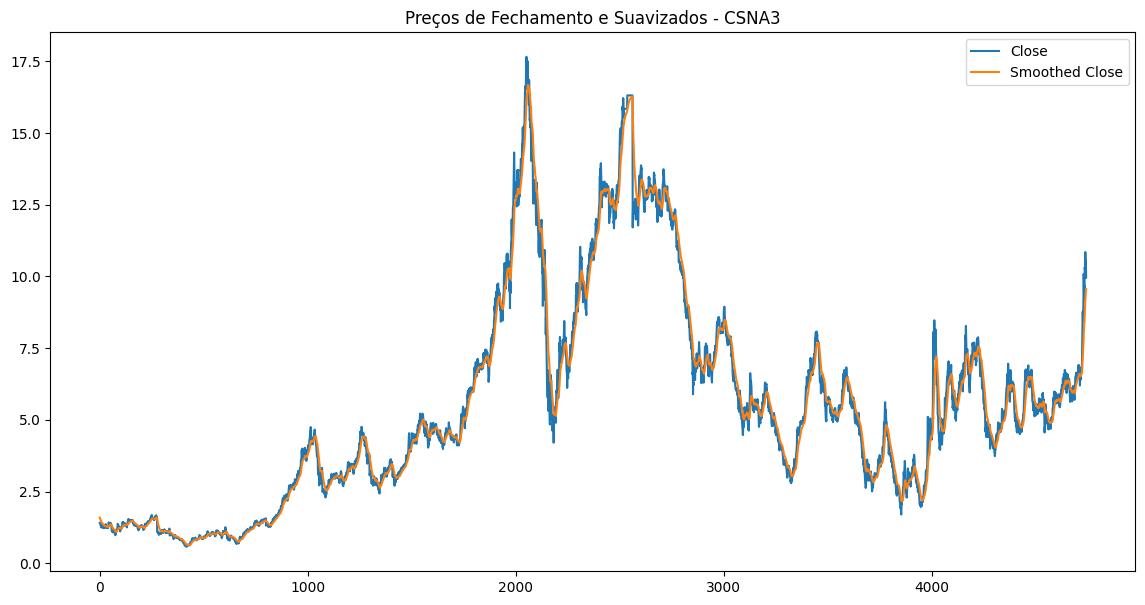

In [6]:
# COMPARAÇÃO ENTRE PREÇOS DE FECHAMENTO E PREÇOS DE FECHAMENTO SUAVIZADOS
plt.figure(figsize=(14, 7))
plt.plot(df_train['Close'], label='Close')
plt.plot(df_train['Smoothed_Close'], label='Smoothed Close')
plt.title(f'Preços de Fechamento e Suavizados - {nome_arquivo}')
plt.legend()
plt.show()

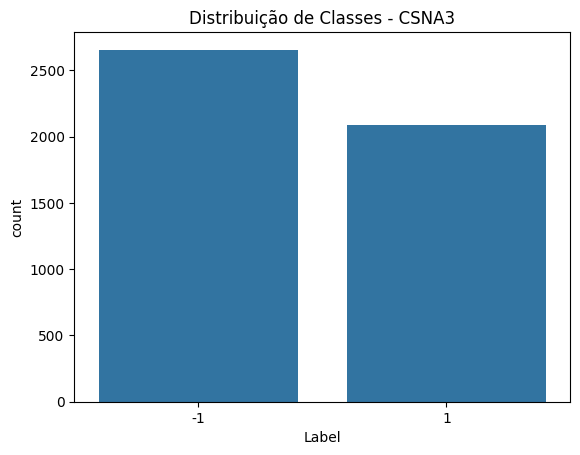

In [7]:
# DISTRIBUIÇÃO DOS RÓTULOS
sns.countplot(x='Label', data=df_train)
plt.title(f'Distribuição de Classes - {nome_arquivo}')
plt.show()

## Treinamento de modelo de Redes Neurais Recorrentes (RNN)

In [8]:
## NORMALIZAÇÃO DOS DADOS

# Normalizador para as features
scaler = StandardScaler()

# Função para converter rótulos em formato categórico
def converter_para_categorico(y):
    if y.min() == -1:  # Se os rótulos forem -1 e 1
        y = (y + 1) // 2  # Converter rótulos para 0 e 1
    return to_categorical(y)

X_train = df_train.drop(['Date', 'Close', 'Smoothed_Close', 'Label'], axis=1)
y_train = df_train['Label']

X_test = df_test.drop(['Date', 'Close', 'Smoothed_Close', 'Label'], axis=1)
y_test = df_test['Label']

# Normalizar as features
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# reshape da entrada para ser [amostras, time steps, caracteristicas]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Converter os rótulos para formato categórico
y_train_cat = converter_para_categorico(y_train)
y_test_cat = converter_para_categorico(y_test)

In [9]:
# Cria e treina a rede LSTM
historicos = {}

model_rnn = Sequential([
        # Adicionando a primeira camada LSTM
        # 50 unidades referem-se ao número de neurônios na camada
        # return_sequences=True para passar sequências para a próxima camada LSTM
        # input_shape define o formato esperado dos dados de entrada       
        LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
        # Segunda camada LSTM com 50 unidades
        LSTM(50),
        # Camada densa com 50 neurônios e função de ativação ReLU
        Dense(50, activation='relu'),
        # Camada de saída densa com uma unidade por classe esperada
        # Com funcao de ativacao sigmoid para classificação binária
        Dense(y_train_cat.shape[1], activation='sigmoid')
    ])

# Compilando o modelo com entropia cruzada categórica para classificação binária
# A acurácia é usada como métrica para avaliação
model_rnn.compile(loss='binary_crossentropy', metrics=['accuracy'])

# Treinando o modelo com os dados
# Epochs define o número de vezes que o modelo verá todo o conjunto de dados
# Batch size é o número de amostras que o modelo vê antes de atualizar os pesos
# Verbose=1 mostra a barra de progresso do treinamento

checkpointer = ModelCheckpoint(filepath='../models/melhor_rnn_CSNA3.keras', verbose=1,  save_best_only=True, monitor='val_accuracy')

historico_rnn = model_rnn.fit(X_train, y_train_cat, epochs=100, batch_size=8, validation_split=0.2, verbose=1, callbacks=[checkpointer],shuffle=True)


Epoch 1/100


/Users/cintia.duarte/Documents/develop/NEURAL-NETWORKS-REGRESSION/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


470/475 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5473 - loss: 0.6899
Epoch 1: val_accuracy improved from -inf to 0.59326, saving model to ../models/melhor_rnn_CSNA3.keras
475/475 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5473 - loss: 0.6899 - val_accuracy: 0.5933 - val_loss: 0.6840
Epoch 2/100
466/475 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5399 - loss: 0.6876
Epoch 2: val_accuracy improved from 0.59326 to 0.61012, saving model to ../models/melhor_rnn_CSNA3.keras
475/475 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5402 - loss: 0.6875 - val_accuracy: 0.6101 - val_loss: 0.6483
Epoch 3/100
465/475 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5857 - loss: 0.6638
Epoch 3: val_accuracy did not improve from 0.61012
475/475 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5864 - loss: 0.6634 - val_accuracy: 0.5901 - val_loss: 0.6178
Epoch 4/100
469/475 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6531 - loss: 0.5881
Epoch 4: val_accuracy improved from 0.61012 to 0.76607,

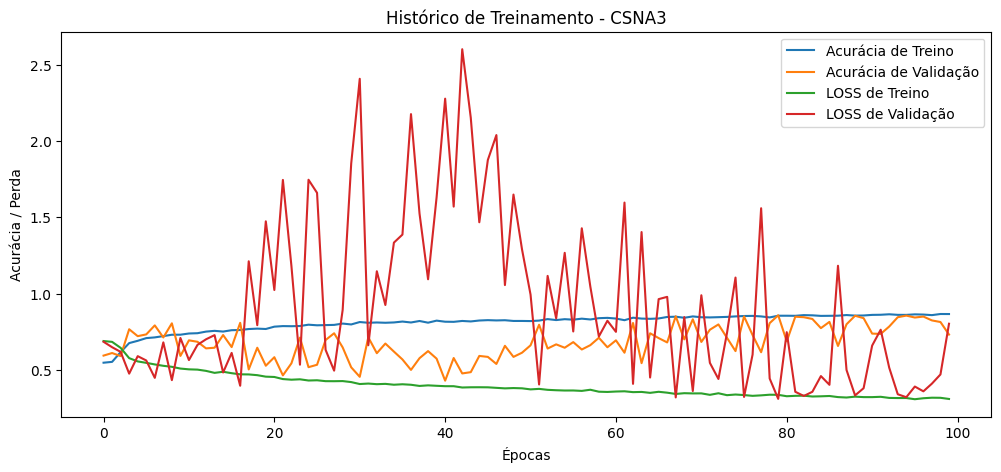

In [10]:
def plotar_historico(historico, titulo):
    plt.figure(figsize=(12, 5))
    plt.plot(historico.history['accuracy'], label='Acurácia de Treino')
    if 'val_accuracy' in historico.history:
        plt.plot(historico.history['val_accuracy'], label='Acurácia de Validação')
    plt.plot(historico.history['loss'], label='LOSS de Treino')
    if 'val_loss' in historico.history:
        plt.plot(historico.history['val_loss'], label='LOSS de Validação')
    plt.title(titulo)
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia / Perda')
    plt.legend()
    plt.show()

plotar_historico(historico_rnn, f"Histórico de Treinamento - {nome_arquivo}")

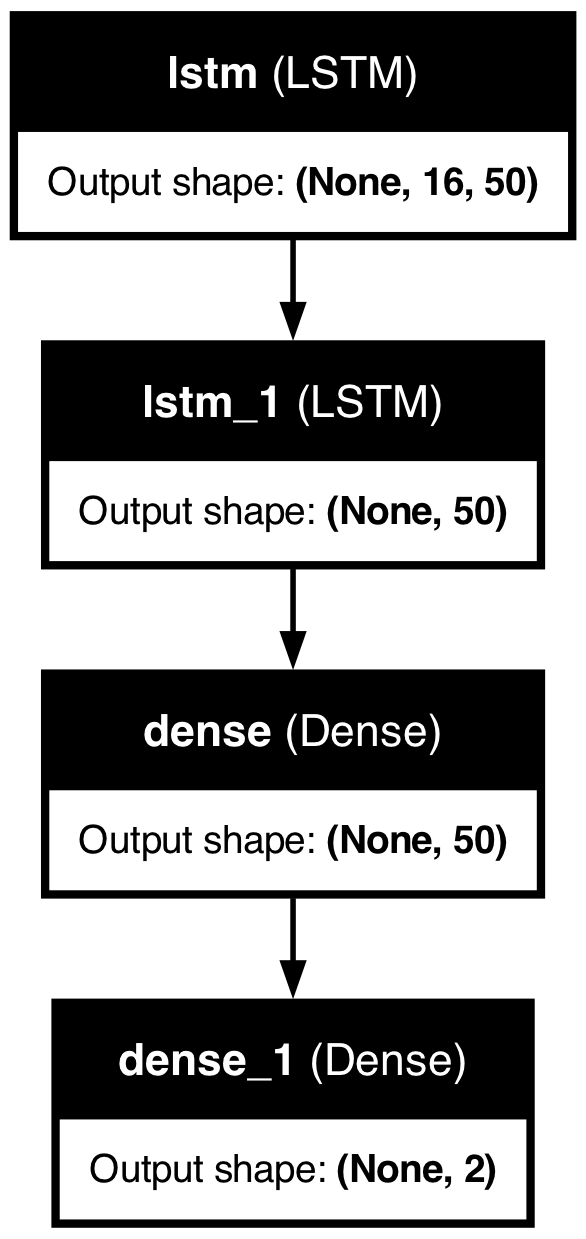

In [11]:
plot_model(model_rnn,show_shapes=True, show_layer_names=True)

CSNA3 -> Acurácia: 54.22%
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Relatório de Classificação para CSNA3:
               precision    recall  f1-score   support

           0       0.68      0.40      0.50       688
           1       0.47      0.74      0.58       498

    accuracy                           0.54      1186
   macro avg       0.58      0.57      0.54      1186
weighted avg       0.59      0.54      0.53      1186




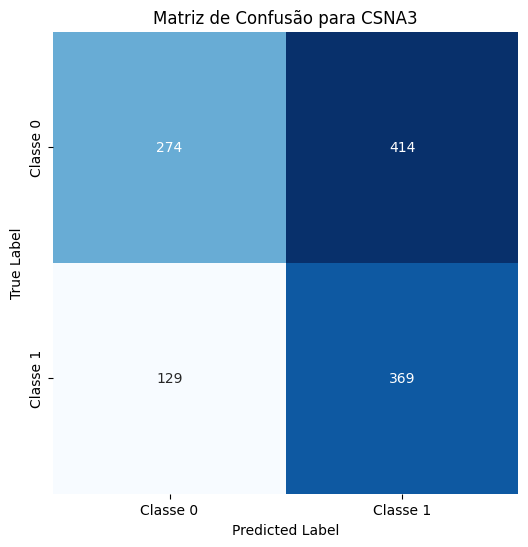

In [12]:
# Função para plotar a matriz de confusão
def plotar_matriz_confusao(cm, classes, title):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)

# Avaliar o modelo
scores = model_rnn.evaluate(X_test, y_test_cat, verbose=0)
print(f"{nome_arquivo} -> Acurácia: {scores[1]*100:.2f}%")

# Predições
y_pred = model_rnn.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_teste_classes = np.argmax(y_test_cat, axis=1)

# Gerar e plotar a matriz de confusão
cm = confusion_matrix(y_teste_classes, y_pred_classes)
plotar_matriz_confusao(cm, classes=['Classe 0', 'Classe 1'], title=f'Matriz de Confusão para {nome_arquivo}')

# Gerar relatório de classificação
print(f"Relatório de Classificação para {nome_arquivo}:\n {classification_report(y_teste_classes, y_pred_classes)}\n")

## Treinamento de Redes Neurais Convolucionais (CNN)